In [24]:
from avgmentations import augmentations, resnet_dataset, utils, losses
from avgmentations.resnet_dataset import RESNET_MEAN, RESNET_STD
import numpy as np
from torchvision import datasets, models, transforms
from torchvision.transforms import Compose, ToTensor, Resize
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
import torch
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from copy import copy
import time
from PIL import Image
import importlib

#splits the train data to train and validation sets
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    
    datasets['train'].dataset = copy(dataset)
    #these train and val basic augmentation are done at loading images 
    #it's data preprocessing don't modify it
    datasets['train'].dataset.transform = transforms.Compose([
    
    	transforms.ToTensor(),
    	transforms.Normalize(mean, std)
            ])
            
    datasets['val'].dataset.transform = transforms.Compose([
 		
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
            ])
    return datasets

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

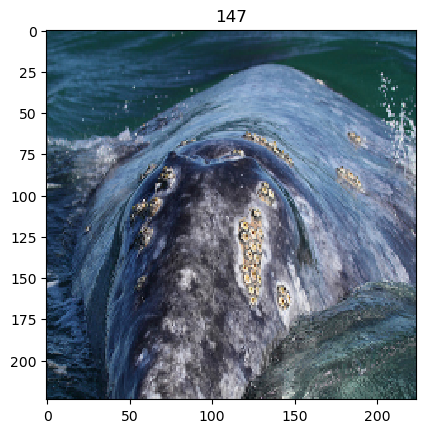

tensor(65)


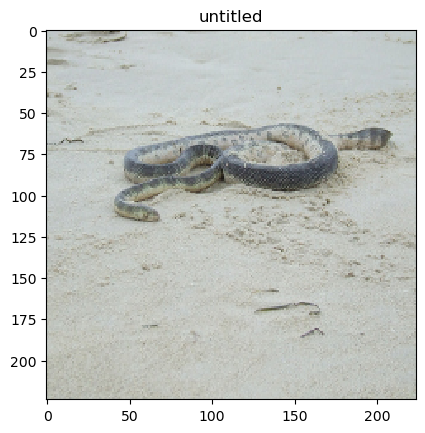

In [33]:
import os

class TestDataset(datasets.VisionDataset):

    def __init__(self, root, labels_file, transform=None, target_transform=None):
        super().__init__(root=root, transform=transform, target_transform=target_transform)

        paths = sorted(os.listdir(self.root))
        paths = [f'{self.root}/{p}' for p in paths]
        with open(os.path.expanduser(labels_file)) as f:
            labels = f.read().splitlines()
        labels = [int(l) for l in labels]
        self.samples = list(zip(paths, labels))

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        sample = datasets.folder.pil_loader(path)
        
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return sample, target

    def __len__(self):
        return len(self.samples)

test_dataset = TestDataset(
    root='../../ImageNet50/test', 
    labels_file='../../ImageNet50/ILSVRC2012_test_ground_truth.txt',
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(RESNET_MEAN, RESNET_STD),
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
    ])
)

idx = 15
utils.imshow(test_dataset[idx][0], title=test_dataset[idx][1])

if True:
    dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=0)
    for inputs, labels in dataloader:
        print(labels[0])
        utils.imshow(inputs[0])
        break

In [3]:
importlib.reload(resnet_dataset)
importlib.reload(augmentations)
importlib.reload(utils)

default_dataset = ImageFolder(
    root = 'train_sub',
    transform = utils.DEFAULT_AUGMENTATION,
    target_transform = augmentations.OneHot(10)
)

t = {
        0: augmentations.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            augmentations.OneOf([
                augmentations.MixUp(default_dataset, min_lam=0.3, max_lam=0.7),
                augmentations.CutMix(default_dataset, min_lam=0.3, max_lam=0.7),
                augmentations.CutOut(2, 50)
            ], p=[0.25,0.5,0.25]),
            augmentations.P(augmentations.MixUp(default_dataset, min_lam=0.3, max_lam=0.7), 0.5),
            augmentations.GridMask(),
            augmentations.AugMix()
        ])
    }

dataset = resnet_dataset.ResNetImageFolder(
    'train_sub',
    {
        0: augmentations.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            augmentations.MixUp(default_dataset, min_lam=0.3, max_lam=0.7),
        ]),
        3: augmentations.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            augmentations.CutMix(default_dataset, min_lam=0.3, max_lam=0.7),
        ])
    }
)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7034, 0.2966, 0.0000,
        0.0000])


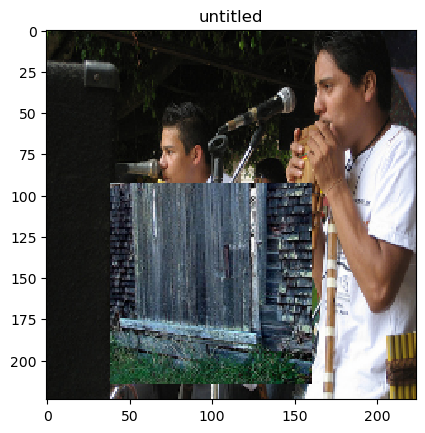

In [9]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True, num_workers=2)
dataset.update_transform(3)
for inputs, labels in dataloader:
    print(labels[0])
    utils.imshow(inputs[0])
    break

target
 tensor([0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.7000])


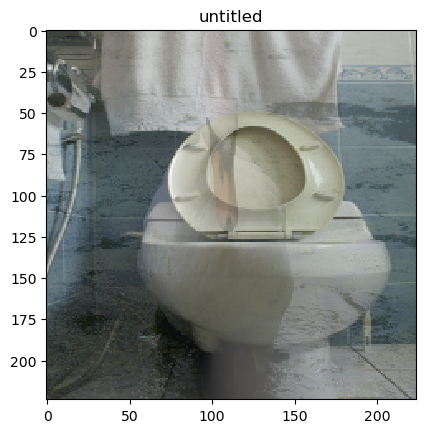

In [12]:
dataset.update_transform(0)
img, target = dataset[0]

print('target\n', target)
utils.imshow(img)

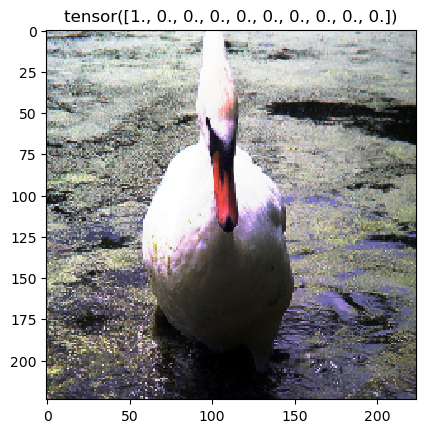

In [18]:
dataset = resnet_dataset.ResNetImageFolder(
    'train_sub',
    {
        0: transforms.Compose([
            transforms.AutoAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.Resize((256,256)),
            transforms.CenterCrop(224),
        ])
    }
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=False, num_workers=0)

for inputs, labels in dataloader:
    utils.imshow(inputs[0], labels[0])
    break

## Double Example

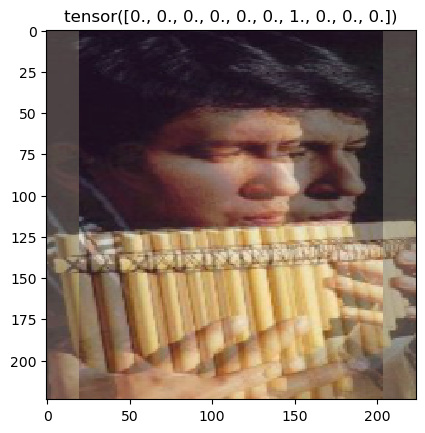

In [15]:
dataset = resnet_dataset.ResNetImageFolder(
    'train_sub',
    {
        0: transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.Resize((256,256)),
            transforms.CenterCrop(224),
            augmentations.Double(20), # Custom Double Augmentation
        ])
    }
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True, num_workers=2)

for inputs, labels in dataloader:
    utils.imshow(inputs[0], labels[0])
    break

## CutOut Example

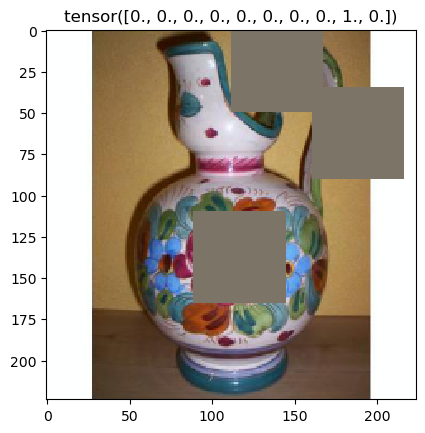

In [16]:
dataset = resnet_dataset.ResNetImageFolder(
    'train_sub',
    {
        0: transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            augmentations.CutOut(3, 56), # Custom Cutout Augmentation
        ])
    }
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True, num_workers=2)

for inputs, labels in dataloader:
    utils.imshow(inputs[0], labels[0])
    break

## GridMask Example

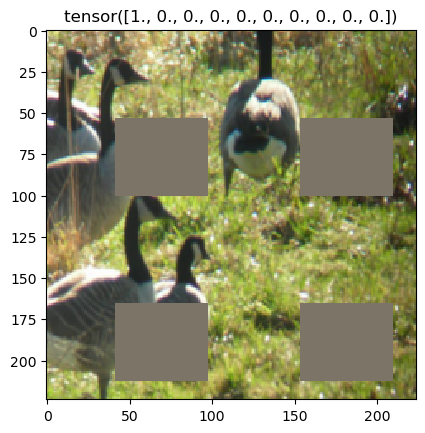

In [19]:
dataset = resnet_dataset.ResNetImageFolder(
    'train_sub',
    {
        0: transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            augmentations.GridMask(), # Custom GridMask Augmentation
        ])
    }
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True, num_workers=2)

for inputs, labels in dataloader:
    utils.imshow(inputs[0], labels[0])
    break

## AugMix Example

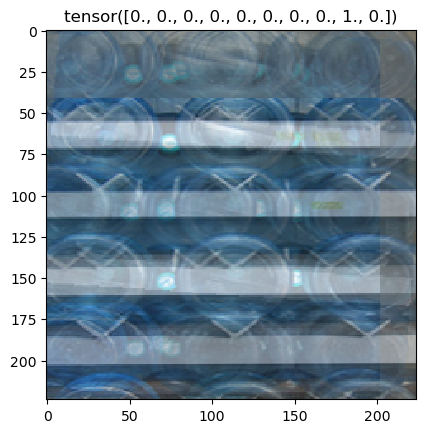

In [7]:
dataset = resnet_dataset.ResNetImageFolder(
    'train_sub',
    {
        0: transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.Resize((256,256)),
            transforms.CenterCrop(224),
            augmentations.AugMix()   
        ])
    }
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True, num_workers=0)

for inputs, labels in dataloader:
    utils.imshow(inputs[0], labels[0])
    break

## Mixup Example

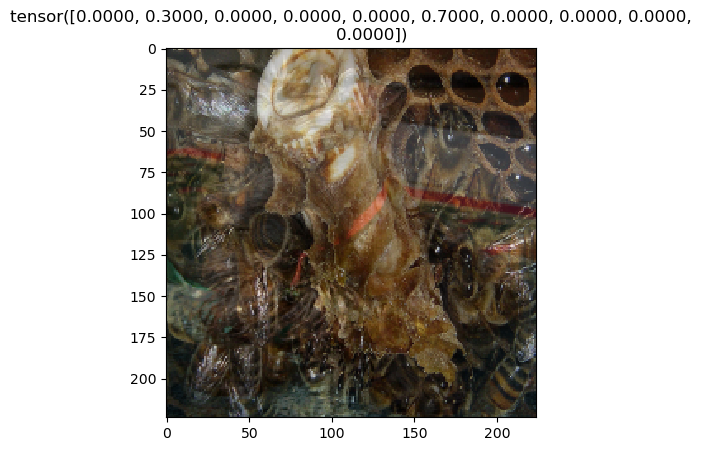

In [28]:
default_dataset = ImageFolder(
    'train_sub', 
    transform = utils.DEFAULT_AUGMENTATION, 
    target_transform=augmentations.OneHot(10)
)
dataset = resnet_dataset.ResNetImageFolder(
    'train_sub',
    {
        0: augmentations.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            augmentations.MixUp(default_dataset)
        ])
    }
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True, num_workers=2)

for inputs, labels in dataloader:
    utils.imshow(inputs[0], labels[0])
    break

# CutMix Example

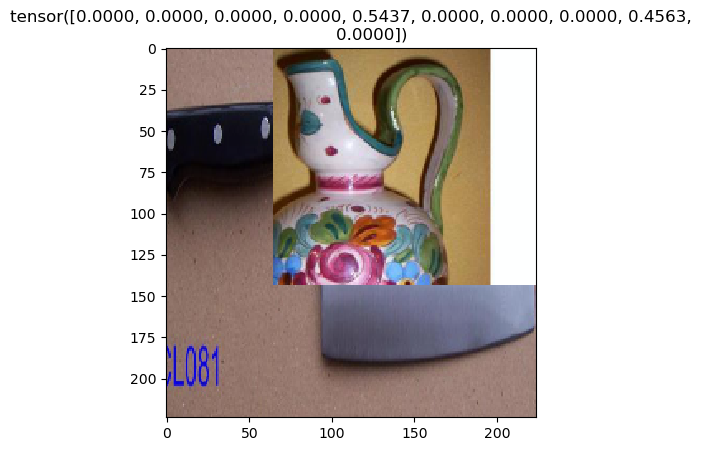

In [42]:
default_dataset = ImageFolder(
    'train_sub', 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ]),
    target_transform=augmentations.OneHot(10)
)
dataset = resnet_dataset.ResNetImageFolder(
    'train_sub',
    {
        0: augmentations.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            augmentations.CutMix(default_dataset, alpha=2)
        ])
    }
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True, num_workers=0)

for inputs, labels in dataloader:
    utils.imshow(inputs[0], labels[0])
    break

# Augmentations in the Model

In [355]:
#### TRAIN FUNCTION ####
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

#    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            dataset.update_transform(epoch)
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                #print(labels.size())

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)
                targets = torch.max(labels.data, dim=1).indices
                running_corrects += torch.sum(preds == targets)
            #out = torchvision.utils.make_grid(inputs)
            #imshow(out, title=['train'+str(x.item()) for x in labels])
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
#                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
#    model.load_state_dict(best_model_wts)
    return model

In [361]:
importlib.reload(resnet_dataset)
importlib.reload(augmentations)
importlib.reload(utils)
importlib.reload(losses)

cw_path = '/Users/austin-pan/Documents/other/academic/y4/av/cw/'
default_dataset = ImageFolder(
    cw_path + 'ImageNet50/train', 
    transform = utils.DEFAULT_AUGMENTATION, 
    target_transform=augmentations.OneHot(1000)
)
dataset = resnet_dataset.ResNetImageFolder(
    cw_path + 'ImageNet50/train', # 'train_sub',
    {
        0: augmentations.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            augmentations.MixUp(default_dataset)
        ])
    }
)

# Gets separated data
image_datasets = train_val_dataset(dataset)

# Dataloader shuffles both train and valid!!! image_datasets
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=5,
        shuffle=True, 
        num_workers=2
    )
    for x in ['train','val']
}

# Full dataset size needed for training              
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

# Declaring the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=False)
#freeze first two layers
ct = 0
for child in model.children():
    ct += 1
    if ct < 3:
        for param in child.parameters():
            param.requires_grad = False

#FILE = cw_path + "/resnet50_fconv_model_best.pth.tar"
#checkpoint = torch.load(FILE, map_location=device)

model = nn.DataParallel(model)
#model.load_state_dict(checkpoint['state_dict'])

criterion = losses.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.006, weight_decay=0.006)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

model = model.to(device)

train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
data tensor([[ 0.1256,  0.2246, -0.4134,  ...,  0.7402, -0.5128, -0.1050],
        [ 0.0065,  0.3257, -0.8580,  ...,  0.8931, -0.7856,  0.0469],
        [ 0.1366,  0.2347, -0.3452,  ...,  0.6327, -0.8250, -0.1406],
        [-0.0061,  0.5210, -0.2987,  ...,  0.7239, -0.6328,  0.0025],
        [ 0.0552,  0.4185, -0.3868,  ...,  0.8755, -0.6406, -0.0510]],
       grad_fn=<AddmmBackward0>)
log_softmax(data) tensor([[-6.9542, -6.8552, -7.4932,  ..., -6.3396, -7.5926, -7.1848],
        [-7.1699, -6.8507, -8.0344,  ..., -6.2833, -7.9621, -7.1295],
        [-6.8981, -6.8000, -7.3799,  ..., -6.4020, -7.8597, -7.1753],
        [-7.0597, -6.5326, -7.3522,  ..., -6.3297, -7.6864, -7.0511],
        [-7.0170, -6.6537, -7.4590,  ..., -6.1966, -7.7127, -7.1231]],
       grad_fn=<LogSoftmaxBackward0>)
target tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0.,

KeyboardInterrupt: 